In [594]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from librosa import get_duration, get_samplerate
from maad import sound
from maad.util import power2dB, read_audacity_annot, format_features, overlay_rois

from os import listdir
from os.path import isfile, join

from utils import plot_listen_examples
from utils import roi2windowed, find_file

from itertools import groupby
from operator import itemgetter

plt.rcParams["figure.figsize"] = (19,7)

pd.options.mode.chained_assignment = None  # default='warn'

# Read Labels:

In [612]:
def load_annotations(path_annot, verbose=False):
    """ load all audacity annotations on a folder """
    annotation_files = [f for f in listdir(path_annot) if isfile(join(path_annot, f))]
    if verbose:
        print('Number of files:',len(annotation_files))
        files = [i.split('.')[-1] for i in annotation_files]
        print('Fortmats:',set(files))
        print()
        print('Frequency of files:',pd.Series(files).value_counts())
        files_names = [i.split('.')[0] for i in annotation_files]
        print()
        print('Unique names:',len(files_names))

    df_all_annotations_ = pd.DataFrame()
    for file in annotation_files:
       
        #y, sr = sound.load(recordings_folder+file.split('.')[0]+'.wav')
        #duration = round(get_duration(y=y, sr=sr))
        #if sr != 22050:
        #    print(sr, file)
        #if duration != 60:
        #    print(duration, file)
        #Sxx_power, tn, fn, ext = sound.spectrogram(s, fs, nperseg=1024, noverlap=1024//2)
        #Sxx_db = power2dB(Sxx_power) + 96 # why 96?
        df_rois = read_audacity_annot(annotations_folder+file) 
        #df_rois = format_features(df_rois, tn, fn)
        df_rois[['site','date']] = file.split('.txt')[0].split('_',1)
        df_rois['fname'] = file.split('.')[0]
        df_all_annotations_ = df_all_annotations_.append(df_rois,ignore_index=True) 
    df_all_annotations = df_all_annotations_.copy()
    df_all_annotations['min_t'] = np.floor(df_all_annotations['min_t'])
    df_all_annotations['max_t'] = np.ceil(df_all_annotations['max_t'])
    df_all_annotations['date'] = df_all_annotations['date'].str.split('_').apply(lambda x: x[0]+x[1])
    df_all_annotations['date'] = pd.to_datetime(df_all_annotations['date'])
    df_all_annotations[['label','quality']] = df_all_annotations_['label'].str.split('_',expand=True)
    df_all_annotations['label'] = df_all_annotations['label'].replace({'BPAFAB':'BOAFAB','PHUCUV':'PHYCUV'})
    df_all_annotations['quality'] = df_all_annotations['quality'].replace({'FAR':'F','MED':'M','CLR':'C'})
    df_all_annotations = df_all_annotations[['site', 'fname', 'date','label',
                                             'quality']+ list(df_all_annotations.columns[1:-4])]

    df_all_annotations = df_all_annotations.sort_values(by=['fname','min_t','max_t'],ignore_index=True)
    df_all_annotations['label_duration'] = df_all_annotations['max_t'] - df_all_annotations['min_t']

    return df_all_annotations

def batch_format_rois(df, wl, prefix):
    """ format rois to a fixed length window"""
    rois_fmt = pd.DataFrame()
    for idx, roi in df.iterrows():
        roi_fmt = roi2windowed(wl, roi)
        roi_fmt['fname'] = roi.fname
        rois_fmt = rois_fmt.append(roi_fmt)

    rois_fmt.reset_index(inplace=True, drop=True)
    rois_fmt['fname_sample'] = prefix + rois_fmt.index.astype(str).str.zfill(4) + '.wav'
    return rois_fmt

def batch_write_samples(rois, wav_path, target_sr,path_save,flims,verbose=False):
    for idx, roi in rois.iterrows():
        if verbose:
            print(find_file(roi.fname+'.wav', search_path=wav_path))
        s, fs = sound.load(find_file(roi.fname, search_path=wav_path))
        # format audio
        s_trim = sound.trim(s, target_sr, min_t=roi.min_t, max_t=roi.max_t, pad=True)
        s_resampled = sound.resample(s_trim, fs, target_sr)
        s_filtered = maad.sound.select_bandwidth(s_resampled,target_sr,fcut=flims, forder=5, fname ='butter', ftype='bandpass')
        s_normalized = sound.normalize(s_filtered, max_amp=0.7)
        # create folder?
        fname_save = os.path.join(path_save, roi.fname_sample)
        # write
        sound.write(fname_save, target_sr, s_normalized, bit_depth=16)
        
def planilha(n_sample, wl, prefix, check=False):
    
    df_planilha = pd.read_excel('INCT20955/raw/Planilha_INCT_Anderson_Selvino.xlsx',engine='openpyxl')
    df_planilha = df_planilha[df_planilha['gravador']=='INCT20955']
    df_planilha = df_planilha[['gravacao_id','Boa_fab', 'Phy_cuv']]
    df_planilha['label'] = df_planilha.apply(lambda x: 'Absence' if x['Boa_fab']+x['Phy_cuv']==0 else 'Presence',axis=1)
    gravacao_in_planilha = set(df_planilha[df_planilha['label']==1]['gravacao_id'])
    absence_in_planilha = set(df_planilha[df_planilha['label']==1]['gravacao_id'])
    df_planilha_absence = df_planilha[df_planilha['label']=='Absence']
    df_planilha_absence = df_planilha_absence[['gravacao_id','label']]
    df_planilha_absence['min_t'] = 0
    # get durations
    df_planilha_absence['max_t'] = 60
    df_planilha_absence['min_f'] = np.nan
    df_planilha_absence['max_f'] = np.nan
    df_planilha_absence = df_planilha_absence.rename(columns={'gravacao_id':'fname'})
    # df_planilha['absence'].value_counts()
    # check if gravacao in planilha not annotated
    # gravacao_in_planilha - 
    # check if annotated file not in planilha
    # - gravacao_in_planilha
    # check if some recording not identified in planilha
    # recordings-(absence_in_planilha | gravacao_in_planilha)
    # check if some recording not identified in planilha
    # (absence_in_planilha | gravacao_in_planilha)-recordings
    df_planilha_absence_windows = batch_format_rois(df_planilha_absence, wl=wl, prefix=prefix)

    return df_planilha_absence_windows.sample(n=n_sample)#, ignore_index=True)

def get_absence_slots_in_presence_files(df_all_annotations, max_val=60):
    
    df_absence_space = df_all_annotations.copy()
    df_absence_space['segment_label'] = df_absence_space.apply(lambda x: list(range(int(x['min_t']),int(x['max_t']+1))),axis=1)
    df_absence_space = df_absence_space.groupby(['site','fname','date'])['segment_label'].apply(sum).to_frame().reset_index()
    df_absence_space['absence_space'] = df_absence_space['segment_label'].apply(lambda x: sorted(set(range(61))-set(x)))
    absence_slots = []
    for idx, x in df_absence_space.iterrows():
        sub_segments = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(x['absence_space']), lambda i_x: i_x[0] - i_x[1])]
        absence_slots.extend([[x['site'],x['fname'],x['date'],'Absence',min(i),max(i)] for i in sub_segments if len(i) >= wl])
    df_absence_slots = pd.DataFrame(absence_slots,columns=['site','fname','date','label','min_t','max_t'])
    df_absence_slots['label_duration'] = df_absence_slots['max_t']-df_absence_slots['min_t']
    df_absence_slots['min_f'] = np.nan
    df_absence_slots['max_f'] = np.nan
    return df_absence_slots

In [613]:
def build_dataset(wav_path, annotation_path, wl, target_sr, flims,
                  path_save, prefix='SAMPLE_', label=False, verbose=False):
    """
    Parameters 
    ---------- 
    wav_file: str
        Path of recording file. 
        We expect .wav format
    annotation_file: str
        Path of annotation file. 
        We expect an annotation if .txt format from Audacity
    wl: int
        Fixed window lenght to split the recording
    sr: int
        Sampling rate to convert the audio file
    flims: list
        List composed of [minimun_frequency, maximun_frequency] in Hz
    label: str
        If False return multiclass dataset, in other case return dataset of label specified
        
    Returns 
    ------- 

    
    
    Examples 
    -------- 
  
    
    """
    
    # if 'wav' in wav_file
    # one file
    # if '.txt' in annotation_file
    
    df_all_annotations = load_annotations(path_annot=annotation_path, verbose=verbose)
    if verbose:
        print('read_all_annotations')
    df_presence = batch_format_rois(df=df_all_annotations, wl=wl, prefix=prefix)
    if verbose:
        print('converted to rois')
      
    df_absence_slots = get_absence_slots_in_presence_files(df_all_annotations)
    df_absence_in_presence_files = batch_format_rois(df=df_absence_slots, wl=wl, prefix=prefix)
    
    df_balanced = pd.concat([df_presence,df_absence_in_presence_files])

    presence_samples = df_presence.shape[0]
    absence_samples_in_presence_files = df_absence_in_presence_files.shape[0]
    absence_samples_in_absence_files = presence_samples - absence_samples_in_presence_files
    absence_samples_in_absence_files
    
    df_planilha_absence = planilha(n_sample=absence_samples_in_absence_files,wl=wl,prefix=prefix)
    
    df_balanced = pd.concat([df_balanced, df_planilha_absence])
    
    return df_balanced
    
    #batch_write_samples(df_balanced, wav_path=wav_path, target_sr=target_sr,path_save=path_save,verbose=False)
    #if verbose:
    #    print('saved')

In [614]:
# Binary BOAFAB
wl = 3
sr = 22050
flims = (100,2000)
verbose = True
recordings_folder = 'INCT20955/raw/recordings/'
annotation_path = 'INCT20955/raw/bounding_boxes/'
path_save='INCT20955/batch/'
prefix='SAMPLE_'

dk = build_dataset(wav_path=recordings_folder, annotation_path=annotation_path, wl=wl, target_sr=sr, flims=flims,
                  path_save=path_save, prefix=prefix, verbose=verbose)

Number of files: 130
Fortmats: {'txt'}

Frequency of files: txt    130
dtype: int64

Unique names: 130
read_all_annotations
converted to rois


In [615]:
dk


,site,fname,date,label,quality,min_t,min_f,max_t,max_f,label_duration,fname_sample
0,INCT20955,INCT20955_20190930_210000,2019-09-30 21:00:00,BOAFAB,F,13.5,NaN,16.5,NaN,2,SAMPLE_0000.wav
1,INCT20955,INCT20955_20190930_210000,2019-09-30 21:00:00,BOAFAB,F,19,NaN,22,NaN,1,SAMPLE_0001.wav
2,INCT20955,INCT20955_20190930_210000,2019-09-30 21:00:00,BOAFAB,F,24,NaN,27,NaN,1,SAMPLE_0002.wav
3,INCT20955,INCT20955_20190930_210000,2019-09-30 21:00:00,BOAFAB,F,29,NaN,32,NaN,1,SAMPLE_0003.wav
4,INCT20955,INCT20955_20190930_210000,2019-09-30 21:00:00,BOAFAB,F,32,NaN,35,NaN,1,SAMPLE_0004.wav
...,...,...,...,...,...,...,...,...,...,...,...
3958,NaN,INCT20955_20200211_001500,NaT,Absence,NaN,54,NaN,57,NaN,NaN,SAMPLE_3958.wav
2177,NaN,INCT20955_20191107_220000,NaT,Absence,NaN,51,NaN,54,NaN,NaN,SAMPLE_2177.wav
4230,NaN,INCT20955_20200213_043000,NaT,Absence,NaN,30,NaN,33,NaN,NaN,SAMPLE_4230.wav
4259,NaN,INCT20955_20200213_191500,NaT,Absence,NaN,57,NaN,60,NaN,NaN,SAMPLE_4259.wav


In [ ]:
# Binary BOAFAB
wl = 3
sr = 22050
flims = (100,2000)
verbose = True
recordings_folder = 'INCT20955/raw/recordings/'
annotation_path = 'INCT20955/raw/bounding_boxes/'
path_save='INCT20955/batch/'
prefix='SAMPLE_'

build_dataset(wav_path=recordings_folder, annotation_path=annotation_path, wl=wl, target_sr=sr, flims=flims,
                  path_save=path_save, prefix=prefix, verbose=verbose)

In [ ]:
# Binary PHYCUV
wl = 3
sr = 22050
flims = (300,2000)
verbose=True
recordings_folder = 'INCT20955/raw/recordings/'
annotation_path = 'INCT20955/raw/bounding_boxes/'
path_save='INCT20955/batch/'
prefix='SAMPLE_'

build_dataset(wav_path=recordings_folder, annotation_path=annotation_path, wl=wls, target_sr=sr, flims=flims,
                  path_save=path_save, prefix=prefix, verbose=verbose)

In [ ]:
# Multiclass
wl = 3
sr = 22050
flims = (0,10000)
verbose = True
recordings_folder = 'INCT20955/raw/recordings/'
annotation_path = 'INCT20955/raw/bounding_boxes/'
path_save = 'INCT20955/batch/'
prefix = 'SAMPLE_'

build_dataset(wav_path=recordings_folder, annotation_path=annotation_path, wl=wls, target_sr=sr, flims=flims,
                  path_save=path_save, prefix=prefix, verbose=verbose)

In [97]:
df_all_annotations['date'].describe(datetime_is_numeric=True)

count                             1004
mean     2019-12-13 07:11:57.131473920
min                2019-09-30 21:00:00
25%                2019-11-07 20:15:00
50%                2019-12-13 00:30:00
75%                2020-01-20 21:30:00
max                2020-03-31 21:15:00
Name: date, dtype: object

In [101]:
round(100*df_all_annotations['label'].value_counts(normalize=True),1)

BOAFAB    52.6
PHYCUV    37.6
BOABIS     2.8
BOAPRA     2.2
UND        2.1
SCIPER     2.1
SPHSUR     0.5
LEPLAT     0.1
Name: label, dtype: float64

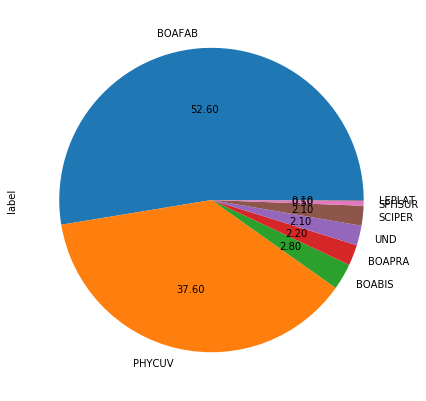

In [102]:
round(100*df_all_annotations['label'].value_counts(normalize=True),1).plot(kind='pie',autopct='%.2f', )

In [103]:
count = dict(round(100*df_all_annotations['label'].value_counts(normalize=True),1))
count.keys()
count.values()

dict_values([52.6, 37.6, 2.8, 2.2, 2.1, 2.1, 0.5, 0.1])

In [104]:
list(count.keys())


['BOAFAB', 'PHYCUV', 'BOABIS', 'BOAPRA', 'UND', 'SCIPER', 'SPHSUR', 'LEPLAT']

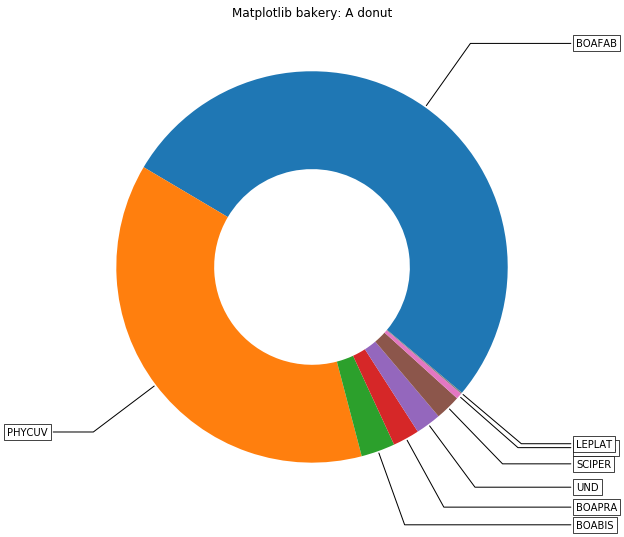

In [105]:
fig, ax = plt.subplots(figsize=(19, 9), subplot_kw=dict(aspect="equal"))

recipe = list(count.keys())


data = list(count.values())

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Matplotlib bakery: A donut")

plt.show()

In [106]:
df.plot.pie(y='mass', figsize=(5, 5))

NameError: name 'df' is not defined

In [108]:
# overlap
df_overlaps = df_all_annotations.groupby(['date']).agg({'label':lambda x: len(set(x))})
df_overlaps['label'].value_counts()

1    68
2    60
6     1
4     1
Name: label, dtype: int64

In [109]:
# FAR, MEDIUM, CLEAR
round(100*df_all_annotations['quality'].value_counts(normalize=True),1)

F    62.0
M    37.1
C     0.9
Name: quality, dtype: float64

In [110]:
df_all_annotations.groupby(['label','quality'])['site'].count()

label   quality
BOABIS  C            4
        F            7
        M           17
BOAFAB  C            4
        F          238
        M          286
BOAPRA  F           21
        M            1
LEPLAT  F            1
PHYCUV  F          323
        M           55
SCIPER  F           21
SPHSUR  F            5
UND     C            1
        F            3
        M           12
Name: site, dtype: int64

In [111]:
df_all_annotations.columns

Index(['site', 'fname', 'date', 'label', 'quality', 'min_t', 'min_f', 'max_t',
       'max_f', 'label_duration'],
      dtype='object')

In [112]:
df_all_annotations[['min_t', 'max_t', 'label_duration']].describe()

,min_t,max_t,label_duration
count,1004.000000,1004.000000,1004.000000
mean,25.010956,33.367531,8.356574
std,18.348484,18.805649,15.833642
min,0.000000,1.000000,1.000000
25%,8.000000,17.000000,1.000000
50%,25.000000,33.000000,2.000000
75%,41.000000,51.000000,5.250000
max,59.000000,61.000000,61.000000


In [114]:
total_label_duration = df_all_annotations['label_duration'].sum()  
total_recording_time = df_all_annotations[['date']].drop_duplicates().shape[0]*60
print('Total duration of recordings:', total_recording_time)
print('Total labels duration:', total_label_duration)

print('Percentage of labels:', round(100*total_label_duration/total_recording_time,1))

Total duration of recordings: 7800
Total labels duration: 8390.0
Percentage of labels: 107.6


In [115]:
df_all_annotations.groupby(['label'])['label_duration'].sum()

label
BOABIS      36.0
BOAFAB    5595.0
BOAPRA      30.0
LEPLAT       1.0
PHYCUV    2666.0
SCIPER      28.0
SPHSUR       7.0
UND         27.0
Name: label_duration, dtype: float32

In [117]:
df_all_annotations.groupby(['date', 'label'])['label_duration'].sum()

date                 label 
2019-09-30 21:00:00  BOAFAB    11.0
2019-10-11 21:45:00  BOAFAB    60.0
                     PHYCUV    32.0
2019-10-11 22:30:00  PHYCUV     9.0
2019-10-11 23:30:00  BOAFAB    36.0
                               ... 
2020-03-14 21:15:00  BOAFAB    60.0
2020-03-31 21:15:00  BOABIS     2.0
                     BOAPRA     7.0
                     SPHSUR     2.0
                     UND        3.0
Name: label_duration, Length: 198, dtype: float32

In [116]:
df_all_annotations.groupby(['date', 'quality'])['label_duration'].sum()

date                 quality
2019-09-30 21:00:00  F          11.0
2019-10-11 21:45:00  F          19.0
                     M          73.0
2019-10-11 22:30:00  F           9.0
2019-10-11 23:30:00  F          36.0
                                ... 
2020-03-14 19:15:00  M          60.0
2020-03-14 20:15:00  M          60.0
2020-03-14 21:15:00  M          60.0
2020-03-31 21:15:00  C           1.0
                     F          10.0
Name: label_duration, Length: 201, dtype: float32

NameError: name 'df_boafab' is not defined

In [120]:
df_boafab = df_all_annotations[(df_all_annotations['label']=='BOAFAB')&(df_all_annotations['quality'].isin(['C','M']))]

In [121]:
df_boafab.head()

,site,fname,date,label,quality,min_t,min_f,max_t,max_f,label_duration
26,INCT20955,INCT20955_20191011_214500,2019-10-11 21:45:00,BOAFAB,M,0.0,NaN,60.0,NaN,60.0
48,INCT20955,INCT20955_20191012_033000,2019-10-12 03:30:00,BOAFAB,M,37.0,NaN,38.0,NaN,1.0
49,INCT20955,INCT20955_20191012_033000,2019-10-12 03:30:00,BOAFAB,M,39.0,NaN,41.0,NaN,2.0
51,INCT20955,INCT20955_20191012_033000,2019-10-12 03:30:00,BOAFAB,M,41.0,NaN,44.0,NaN,3.0
52,INCT20955,INCT20955_20191012_033000,2019-10-12 03:30:00,BOAFAB,M,44.0,NaN,49.0,NaN,5.0


In [122]:
df_boafab[['min_t', 'max_t', 'label_duration']].describe()

,min_t,max_t,label_duration
count,290.000000,290.000000,290.000000
mean,23.110344,38.627586,15.517241
std,19.266882,18.735989,22.616589
min,0.000000,1.000000,1.000000
25%,1.250000,23.000000,1.000000
50%,22.000000,40.500000,3.000000
75%,39.750000,60.000000,18.000000
max,59.000000,61.000000,61.000000


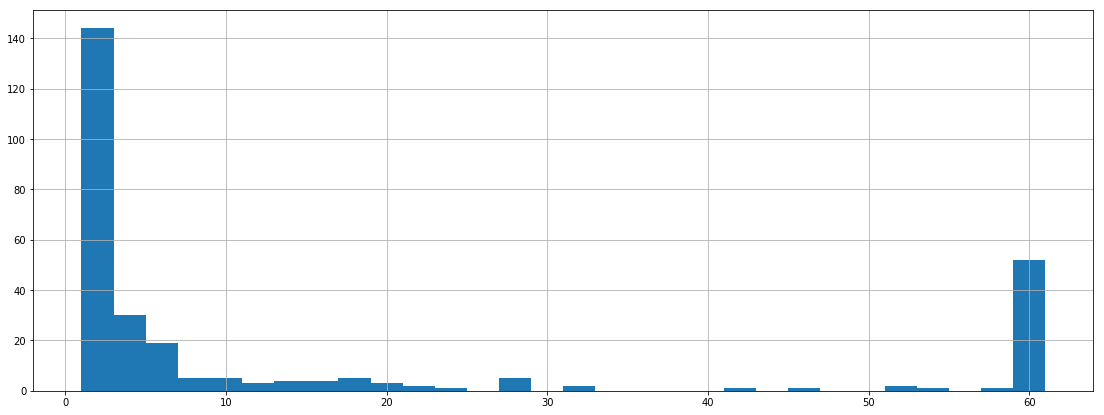

In [123]:
df_boafab['label_duration'].hist(bins=30)

In [124]:
df_boafab 

,site,fname,date,label,quality,min_t,min_f,max_t,max_f,label_duration
26,INCT20955,INCT20955_20191011_214500,2019-10-11 21:45:00,BOAFAB,M,0.0,NaN,60.0,NaN,60.0
48,INCT20955,INCT20955_20191012_033000,2019-10-12 03:30:00,BOAFAB,M,37.0,NaN,38.0,NaN,1.0
49,INCT20955,INCT20955_20191012_033000,2019-10-12 03:30:00,BOAFAB,M,39.0,NaN,41.0,NaN,2.0
51,INCT20955,INCT20955_20191012_033000,2019-10-12 03:30:00,BOAFAB,M,41.0,NaN,44.0,NaN,3.0
52,INCT20955,INCT20955_20191012_033000,2019-10-12 03:30:00,BOAFAB,M,44.0,NaN,49.0,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...
989,INCT20955,INCT20955_20200314_201500,2020-03-14 20:15:00,BOAFAB,M,46.0,NaN,60.0,NaN,14.0
990,INCT20955,INCT20955_20200314_211500,2020-03-14 21:15:00,BOAFAB,M,34.0,NaN,39.0,NaN,5.0
991,INCT20955,INCT20955_20200314_211500,2020-03-14 21:15:00,BOAFAB,M,39.0,NaN,60.0,NaN,21.0
992,INCT20955,INCT20955_20200314_211500,2020-03-14 21:15:00,BOAFAB,M,0.0,NaN,28.0,NaN,28.0


In [126]:
df_boafab['fname'].drop_duplicates().shape

(84,)

In [127]:
df_boafab['subset'] = ['train']*200+['validation']*45+['test']*45

In [ ]:
# 2, 3, 4, 5
segment_lenght = 5

In [ ]:
for file in df_boafab['name'].values[:3]:
    file_name = file.split('.txt')[0]
    plot_listen_examples(recordings_folder+file_name+'.wav')
    
    
    # preprocessing
    
    
    # split segment 
    
    

In [ ]:
plot_listen_examples(recordings_folder)

In [ ]:
"""
Resample and transform samples to 16 bits
Important Note: This script overwrites the samples. Make sure to proceed in a copy of the files
https://github.com/juansulloa/chorus/blob/main/build_dataset/build_mini_dataset_v1/preprocess_FNJV_samples.py

s, fs = sound.load('../data/spinetail.wav')
s_resamp = sound.resample(s, fs, target_fs=fs/2)
print('Number of samples - original audio:', s.shape[0],
      'Number of samples - resampled audio:', s_resamp.shape[0])
_ = sound.spectrogram(s, fs, display=True)
_ = sound.spectrogram(s_resamp, fs/2, display=True)
https://scikit-maad.github.io/generated/maad.sound.resample.html
"""

from maad import sound
import glob


#%% Set variables
fpath = '/Volumes/Audiolib/ML_datasets/AnuraSet/FNJV/audio_files_no_bg/Physalaemus cuvieri/'
target_fs = 22050
bit_depth = 16

#%%

flist = glob.glob(fpath+'*.wav')

for fname in flist:
    print('Processing file ' + fname)
    s, fs = sound.load(fname)
    s_mod = sound.resample(s, fs, target_fs)
    sound.write(fname, target_fs, s_mod, bit_depth)
    

In [ ]:
df = pd.read_csv(folder+'labels_synth.csv')
df['Both'] = df['PHYCUV'] + df['BOAFAB']
print('Size:', df.shape)

In [ ]:
df['PHYCUV'].value_counts()

In [ ]:
df['BOAFAB'].value_counts()

# Interpretation:
- 0 --> No one, noise, othe spe
- 1 --> Only one spec
- 2 --> Both!

In [ ]:
(df['BOAFAB']+df['PHYCUV']).value_counts()

In [ ]:
df.head()

In [ ]:
onlyfiles = [f for f in listdir(recordings_folder) if isfile(join(recordings_folder, f))]
print('Number of files:',len(onlyfiles))
files = [i.split('.')[-1] for i in onlyfiles]
print('Fortmats:',set(files))
print()
print('Frequency of files:',pd.Series(files).value_counts())
files_names = [i.split('.')[0] for i in onlyfiles]
print()
print('Unique names:',len(files_names))

In [ ]:
onlyfiles

# Read Audio

In [ ]:
path_audio = 'INCT20955/raw/recordings' 
for i in range(2):
    file_name = plot_listen_examples(path_audio)

In [ ]:
onlyfiles